In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from environment import Environment
from actor import DenseActor, RandomActor
from critic import Critic
from copy import deepcopy
from tqdm import tqdm
from utils import make_simulation_plot, run_environment_simulation, calculate_full_distance
import or_tools

In [2]:
n_samples_train = 3000
n_samples_test = 50
n_locations = 5
n_steps = n_locations * 2
max_demand = 10
max_capacity = 50
n_epochs = 200
approximation_level = 10

dense_actor = DenseActor(n_locations)
random_actor = RandomActor(n_locations)
critic = Critic()
optimizer = tf.keras.optimizers.legacy.Adam()

env_org = Environment(n_samples_train, n_locations, max_demand, max_capacity)
env_test = Environment(n_samples_test, n_locations, max_demand, max_capacity)

In [3]:
data = or_tools.create_data_model(env_test, 0)

In [4]:
or_tools.or_tools_solve(data)

0 0 9 0 0
1 5 10 0 0
2 6 11 0 0
3 7 12 0 0
4 8 4 0 582
4 4 3 9 696
4 3 1 16 1004
4 1 2 18 1688
4 2 13 22 2464


(2464, 22)

In [18]:
grads_lst = []
losses_train = []
losses_test = []
losses_test_random = []

critic_losses_train = []

all_actions_real_train = []
all_actions_real_test = []
all_actions_real_random = []

all_actions_approximation_train = []
all_actions_approximation_test = []
all_actions_approximation_random = []

In [19]:
for _ in tqdm(range(n_epochs)):
    env_train_process = deepcopy(env_org)
    env_test_process = deepcopy(env_test)
    env_test_process_random = deepcopy(env_test)
    with tf.GradientTape(persistent=True) as tape:
        actions_approximation_train, actions_real_train = run_environment_simulation(
            env_train_process, dense_actor, n_steps, approximation_level
        )
        actions_approximation_test, actions_real_test = run_environment_simulation(
            env_test_process, dense_actor, n_steps, approximation_level
        )

        actions_approximation_test_random, actions_real_test_random = run_environment_simulation(
            env_test_process_random, random_actor, n_steps, approximation_level
        )

        actions_for_critic_train = tf.reshape(actions_approximation_train, (-1, n_samples_train))
        actions_for_critic_train = tf.transpose(actions_for_critic_train)
        critic_estimation_train = critic(env_train_process, tf.convert_to_tensor(actions_for_critic_train))

        full_distance_train = calculate_full_distance(tf.convert_to_tensor(actions_approximation_train))
        loss_train = tf.reduce_sum(full_distance_train)

        full_distance_test = calculate_full_distance(tf.convert_to_tensor(actions_approximation_test))
        loss_test = tf.reduce_sum(full_distance_test)

        full_distance_test_random = calculate_full_distance(tf.convert_to_tensor(actions_approximation_test_random))
        loss_test_random = tf.reduce_sum(full_distance_test_random)

        losses_train.append(loss_train)
        losses_test.append(loss_test)
        losses_test_random.append(loss_test_random)

        advantage_train = full_distance_train - critic_estimation_train
        loss_train_advantage = loss_train * advantage_train
        loss_train_critic = advantage_train**2
        critic_losses_train.append(loss_train_critic)

    all_actions_approximation_train.append(actions_approximation_train)
    all_actions_approximation_test.append(actions_approximation_test)

    all_actions_real_train.append(actions_real_train)
    all_actions_real_test.append(actions_real_test)

    grads = tape.gradient(loss_train_advantage, dense_actor.trainable_variables)
    grads_and_vars = zip(grads, dense_actor.trainable_variables)
    optimizer.apply_gradients(grads_and_vars)
    grads_lst.append(grads)

    critic_grads = tape.gradient(loss_train_critic, critic.trainable_variables)
    critic_grads_and_vars = zip(critic_grads, critic.trainable_variables)
    optimizer.apply_gradients(critic_grads_and_vars)

100%|██████████| 200/200 [11:23<00:00,  3.42s/it]


In [20]:
tf_all_actions_approximation_train = tf.convert_to_tensor(all_actions_approximation_train)
tf_all_actions_approximation_test = tf.convert_to_tensor(all_actions_approximation_test)

tf_all_actions_real_train = tf.convert_to_tensor(all_actions_real_train)
tf_all_actions_real_test = tf.convert_to_tensor(all_actions_real_test)
# shape: [n_epochs x n_steps x n_samples x 2]

In [21]:
tf.reduce_mean(tf_all_actions_approximation_train - tf_all_actions_real_train)

<tf.Tensor: shape=(), dtype=float32, numpy=-1.726198e-05>

In [22]:
def fun(ls, n):
    return [np.mean(ls[i : i + n]) for i in range(0, len(ls) - n)]

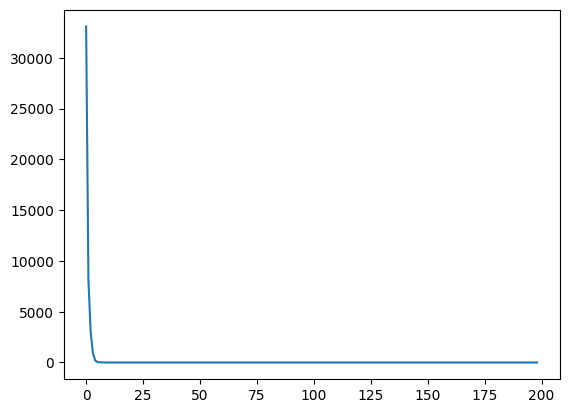

In [23]:
plt.plot(fun(losses_train, 1))
plt.show()

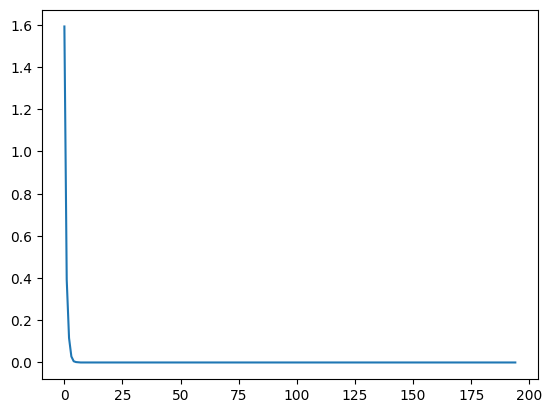

In [24]:
plt.plot(fun(critic_losses_train, 5))
plt.show()

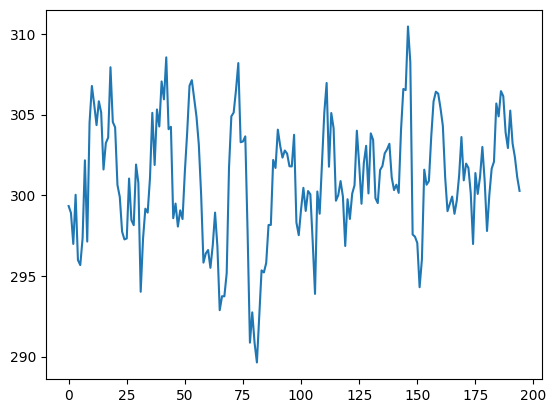

In [25]:
plt.plot(fun(losses_test_random, 5))
plt.show()

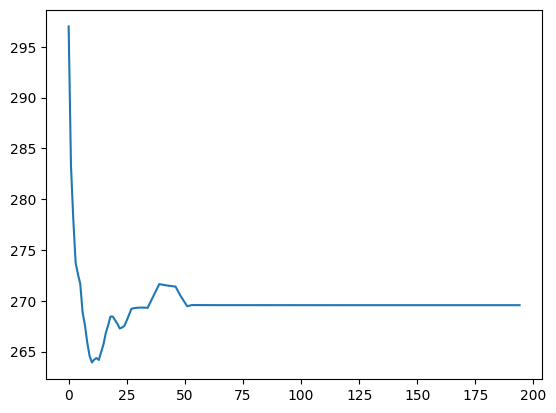

In [26]:
plt.plot(fun(losses_test, 5))
plt.show()
# plt.ylim([0, 250])§

In [32]:
sample_id = 10

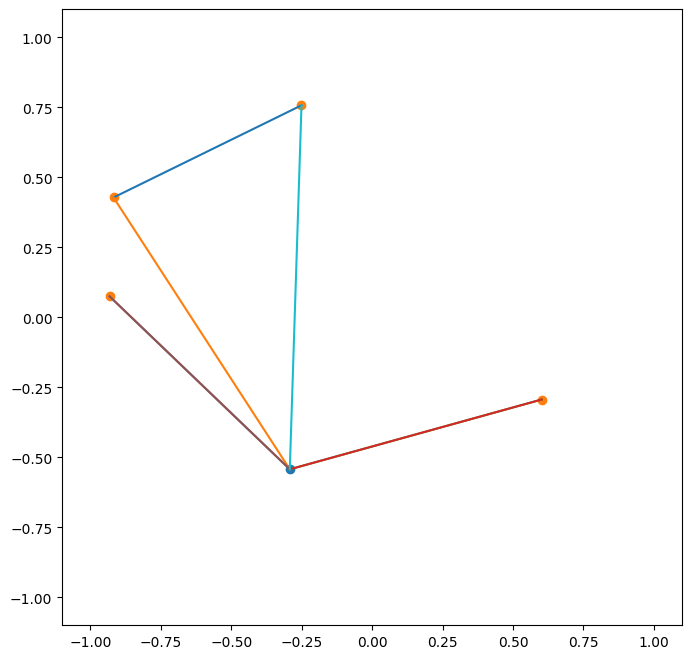

In [33]:
epoch_id = 0

# l1 = calculate_loss(tf_all_actions_real[epoch_id, :, sample_id:sample_id+1, :])
# print(l1.numpy())
make_simulation_plot(env_train_process.locations[sample_id], tf_all_actions_real_train[epoch_id, :, sample_id])

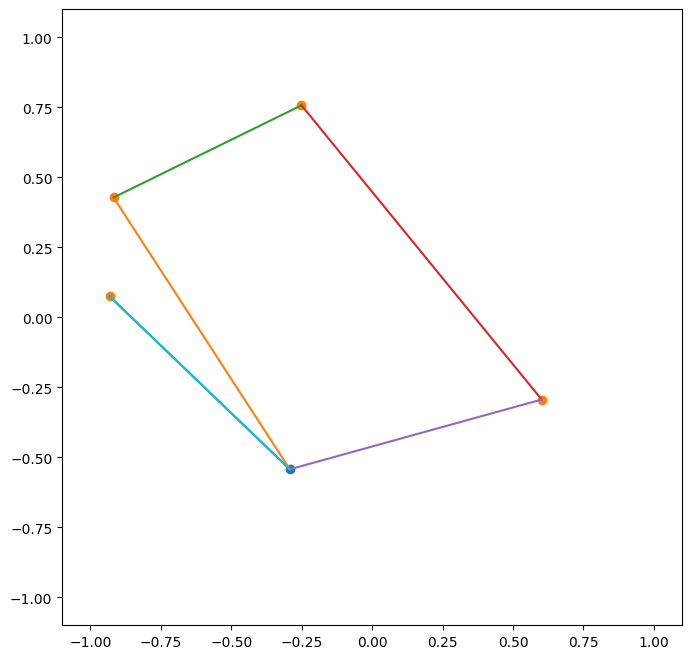

In [34]:
epoch_id = -1

# l1 = calculate_loss(tf_all_actions_real[epoch_id, :, sample_id:sample_id+1, :])
# print(l1.numpy())
make_simulation_plot(env_train_process.locations[sample_id], tf_all_actions_real_train[epoch_id, :, sample_id])